In [299]:
%matplotlib inline 
import numpy as np                       
from matplotlib import pyplot as plt      
import time, sys                   

### Постановка и сеточные параметры

Рассмотрим задачу об эволюции ступеньки. Численное решается уравнение переноса с коэффициентом переноса $c$.

In [300]:
# количество узлов по пространству
nx = 81

# шаг по пространству
dx = 2 / (nx-1)

# количество узлов по времени
nt = 25

# шаг по времени
dt = 0.025

T = dt*(nt-1)

# скорость распространения возмущения (коэффициент переноса)
c = 1

# сетка по пространству
x_mesh = np.linspace(0, 2, nx)

# число Куранта
r = c*dt/dx 

print('r = ', r)
print('T = ', T)

r =  1.0
T =  0.6000000000000001


#### Начальные условия

Зададим 


$$
u(x, 0)=\begin{cases}
    2, \text{ при } x \in [0.5, 1]\\
    1, \text{ иначе}.
\end{cases}
$$

Такая функция называется "ступенька". 

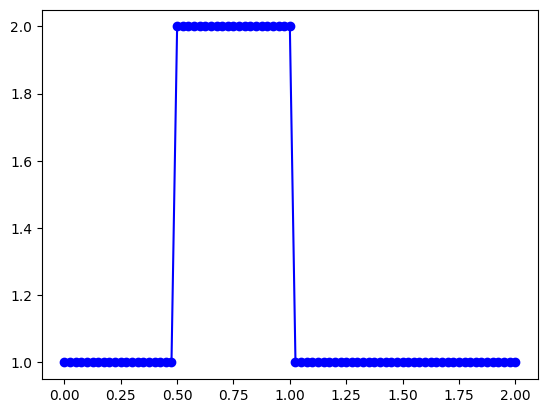

In [301]:
u_init = np.ones(nx)      
u_init[int(0.5/dx):int(1/dx + 1)] = 2  
plt.plot(x_mesh, u_init, '-bo')

#### Точное решение

К моменту времени $T$ ступенька просто сдвинется вправо.

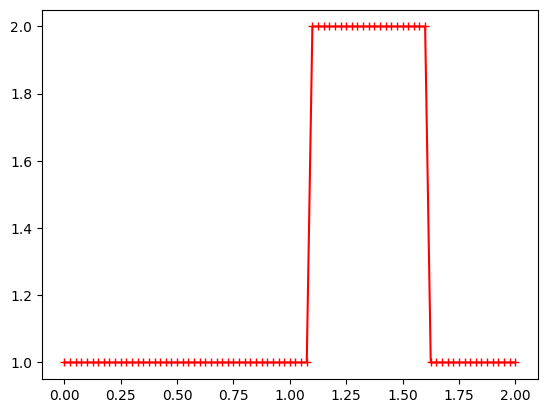

In [302]:
u_exact = np.ones(nx)      
u_exact[int((0.5+c*T) / dx):int((1+c*T)/dx + 1)] = 2  
plt.plot(x_mesh, u_exact, '-r+')

### Численное решение

#### Часть 1. Явный левый уголок
Сначала примените схему *Явный левый уголок* (Upwind scheme). Провести расчеты для $nx = 41; 81; 121$. Построить графики решения

In [303]:
u_n = np.ones(nx)
u = u_init.copy()

for n in range(1, nt):
    u_n = u.copy()
    for i in range(1, nx):
        u[i] = u_n[i] - r*(u_n[i] - u_n[i-1])

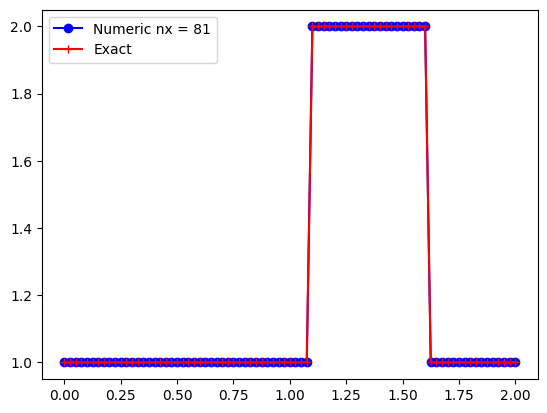

In [304]:
plt.plot(x_mesh, u, '-bo', label = 'Numeric nx = ' + str(nx))
plt.plot(x_mesh, u_exact, '-r+', label = 'Exact')
plt.legend()

При исследовании задачи, например на аппроксимацию, предполагается, что наша функция неразрывная, но так как мы строим наше решение по сетке, то можно считать, что функция "испытывает сильный градиент".

##### 0. *Какой у схемы порядок аппроксимации?*
**Ответ:** у метода *Явный левый уголок* первый порядок аппроксимации по времени и пространству, то есть $O(\tau + h)$.

##### 1. *Удалось ли получить решение? Почему?*
**Ответ:** при $nx = 81$ решение удалось получить, так как число Куранта было равно $r = 1 \leq 1$; при $nx = 121$ решение не удалось получить, так как $r = 1.5 > 1$; при $nx = 41$ решение удалось получить, но наблюдалась *численная диссипация*.

##### 2. *Сколько граничных условий и где нужно поставить в этой задаче?*
**Ответ:** вследствие того, что $\lambda = c > 0$, то нужно задать 1 граничное условие на левой границе.

##### 3. *Почему в задаче явно нигде не инициализируются граничные условия?*
**Ответ:** внутренний цикл по `i` начинается с 1, поэтому значение `u[0]` при каждом шаге времени никогда не меняется и остаётся тем, что было в `u_init[0]`.

##### 4. *Почему в цикле по пространству индексация с 1?* 
**Ответ:** вследствие того, что задача решается с помощью метода *Явный левый уголок*. Элементы с нулевым индексом получаются с помощью граничных условий.


##### 5. *Можно ли решить задачу схемой Явный правый уголок?*
**Ответ:** нет, нельзя, так как для того, чтобы Явный правый уголок сходился необходимо, чтобы число Куранта удовлетворяло неравенству $-1 \leq r \leq 0$.

##### 6. *Почему при решении на 41 узле решение размывается, а на 81 узле нет?*
**Ответ:** для $nx = 81$ число Куранта равно $r = 1$ вследствие чего, групповая скорость приближенного решения совпадает с групповой скоростью точного решения; для $nx = 41$ число Куранта равно $r = 0.5$ и групповые скорости не совпадают.

##### 7. *Объясните причину размытия решения.*
**Ответ:** возникает дисперсия приближенного решения и гармоники с разными значениями $n$ распространяются с разными скоростями. Через некоторое время возникает пространственное разделение этих гармоник, и появляются осцилляции, отсутствующие в точном решении.

#### Часть 2. Схема МакКормака 

Теперь примените схему Мак-Кормака (MacCormack method). Провести расчеты для $nx = 41; 81; 121$. Построить графики решения

In [305]:
u = u_init.copy()
u_pred = np.ones(nx)

for n in range(1, nt): 
    u_n = u.copy()

    # Predictor
    u_pred[0:-1] = u_n[0:-1] - r * (u_n[1:] - u_n[0:-1])
    # u_pred[-1] = u_n[-1] - r * (u_n[0] - u_n[-1])

    # Corrector
    u[1:] = 0.5 * (u_n[1:] + u_pred[1:] - r * (u_pred[1:] - u_pred[0:-1]))
    # u[0] = 0.5 * (u_n[0] + u_pred[0] - r * (u_pred[0] - u_pred[-1]))

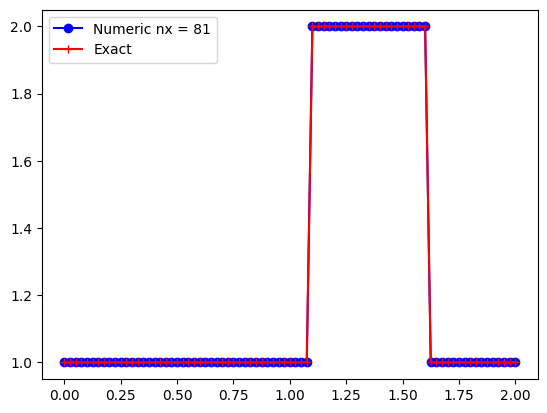

In [306]:
plt.plot(x_mesh, u, '-bo', label = 'Numeric nx = ' + str(nx))
plt.plot(x_mesh, u_exact, '-r+', label = 'Exact')
plt.legend()

##### 0. Какой у схемы порядок аппроксимации?
**Ответ:** cхема МакКормака является схемой второго порядка точности по времени и пространству, т.е. $O(\tau^2 + h^2)$.

##### 1. Удалось ли получить решение? Почему?
**Ответ:** при $nx = 121$ решение не удалось получить, так как $r = 1.5 > 1$; при $nx = 81$ решение удалось получить, так как число Куранта было равно $r = 1 \leq 1$; при $nx = 41$ решение удалось получить, но наблюдалась *численное осциллирование (численная дисперсия)*. Монотонные схемы высокого порядка решают проблему численного осциллирования.

##### 2. *Почему при решении на 41 узле решение осциллирует, а на 81 узле нет?*
**Ответ:** для $nx = 81$ число Куранта равно $r = 1$ вследствие чего, групповая скорость приближенного решения совпадает с групповой скоростью точного решения; для $nx = 41$ число Куранта равно $r = 0.5$ и групповые скорости не совпадают.

##### 3. *Объясните причину осцилляций.*
**Ответ:** возникает дисперсия приближенного решения и гармоники с разными значениями $n$ распространяются с разными скоростями. Через некоторое время возникает пространственное разделение этих гармоник, и появляются осцилляции, отсутствующие в точном решении.

##### 4. *Совпадает ли схема со схемой Лакса-Вендроффа для данной задачи (Lax–Wendroff method)?*
**Ответ:** В линейном случае схемы Мак-Кормака совпадают со схемой Лакса - Вендроффа ("Курс лекций по вычислительной математике", стр. 360).

#### Часть 3. Монотонная схема высокого порядка

1. Можно ли построить линейную монотонную по Годунову схему с порядком выше первого? Почему?
2. Постройте монотонную схему порядка выше первого и примените к решению задачи из предыдущих частей.

Теорма Годунова